In [1]:
!pip install webcolors -qq

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, center_crop
from torchvision.utils import draw_segmentation_masks, make_grid
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from google.colab import drive
import os
drive.mount('/content/drive')

import cv2
import pandas as pd
import numpy as np
import os
import random

from PIL import Image

from webcolors import rgb_to_name

from tqdm import tqdm

%matplotlib inline

Mounted at /content/drive


In [3]:
base_dir = "/content/drive/MyDrive/APS360Project/archive/"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "valid")

classes = pd.read_csv(os.path.join(base_dir, "class_dict.csv"))
annotations = pd.read_csv(os.path.join(base_dir, "metadata.csv"))

In [4]:
print(f"Number of files in the train dir: {len(os.listdir(train_dir))}")
print(f"Number of files in the test dir : {len(os.listdir(test_dir))}")
print(f"Number of files in the valid dir: {len(os.listdir(valid_dir))}")

Number of files in the train dir: 1606
Number of files in the test dir : 172
Number of files in the valid dir: 171


In [5]:
# map classes to RGB values
class_to_rgb = {}
for idx, row in classes.iterrows():
    class_to_rgb[row[0]] = row[1:].to_list()
class_colors = [tuple(x) for x in class_to_rgb.values()]
class_colors

[(0, 255, 255),
 (255, 255, 0),
 (255, 0, 255),
 (0, 255, 0),
 (0, 0, 255),
 (255, 255, 255),
 (0, 0, 0)]

In [6]:
# mapping from land type to colors
{name: rgb_to_name(class_to_rgb[name]) for name in class_to_rgb.keys()}

{'urban_land': 'cyan',
 'agriculture_land': 'yellow',
 'rangeland': 'magenta',
 'forest_land': 'lime',
 'water': 'blue',
 'barren_land': 'white',
 'unknown': 'black'}

In [7]:
def transform_mask(mask, class_colors):
    """
    Transforms a mask from RGB format to a tensor of shape (H, W)
    where a pixel represents the class label
    """
    num_classes = len(class_colors)
    h, w = mask.shape[1:]  # shape expected to be (C, H, W)
    semantic_map = torch.zeros((h, w), dtype=torch.uint8)
    # iterate over all the classes
    for idx, color in enumerate(class_colors):
        color = torch.tensor(color).view(3, 1, 1)  # rgb value
        class_map = torch.all(torch.eq(mask, color), 0)
        semantic_map[class_map] = idx
    return semantic_map


def ohe_mask(mask, num_classes):
    """Turns a label tensor of shape(H, W) to (num_classes, H, W)"""
    return torch.permute(
        F.one_hot(mask.type(torch.long), num_classes=num_classes).type(torch.bool),
        (2, 0, 1),
    )

In [8]:
def process_masks(image_ids, class_colors, in_dir, out_dir):
    for image_id in image_ids:
        mask = read_image(os.path.join(in_dir, f"{image_id}_mask.png"))
        to_pil_image(transform_mask(mask, class_colors)).save(
            os.path.join(out_dir, f"{image_id}_mask.png")
        )

In [9]:
def plot_sample(n=5, class_idx=None):
    # lets plot a few samples
    sample = []
    for i in range(n):
        while True:
            id = np.random.choice(image_ids, 1)[0]
            classes_img = np.unique(
                read_image(os.path.join(transformed_masks_path, f"{id}_mask.png"))
            )
            if class_idx is None:
                sample.append(id)
                break
            elif class_idx in classes_img:
                sample.append(id)
                break
    imgs = []
    for img_id in sample:
        sat_img = read_image(os.path.join(train_dir, f"{img_id}_sat.jpg"))
        masks = ohe_mask(
            read_image(
                os.path.join(transformed_masks_path, f"{img_id}_mask.png")
            ).squeeze(),
            len(class_colors),
        )
        mask_over_image = draw_segmentation_masks(
            sat_img, masks=masks, alpha=0.5, colors=class_colors
        )
        imgs.extend([sat_img, mask_over_image])

    display({name: rgb_to_name(class_to_rgb[name]) for name in class_to_rgb.keys()})
    show(make_grid(imgs, nrow=2))

In [12]:
plot_sample(class_idx=0)

NameError: name 'image_ids' is not defined

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/APS360Project/archive/class_dict.csv")
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [ ]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])

    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        print(image_path)
        print(mask_path)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = Image.fromarray(image)
            mask = Image.fromarray(mask)

            angle = random.randint(-30, 30)

            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)

            image = self.transform(image)
            mask = self.transform(mask)

            if random.random() > 0.5:
              colour_jitter = transforms.ColorJitter(brightness=0.6, contrast=0.5, saturation=0.2, hue=0.1)
              image = colour_jitter(image)
              mask = colour_jitter(mask)

        # fig, axes = plt.subplots(nrows, 4, figsize=(10, 10))
        # axes[0, 0].imshow(image.permute(1, 2, 0))
        # axes[0, 1].imshow(mask.permute(1, 2, 0))
        # plt.tight_layout()
        # plt.show()
        return image, mask


    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

../content/drive/MyDrive/APS360 Project/archive/train/100694_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/100694_mask.png


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


../content/drive/MyDrive/APS360 Project/archive/train/102122_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/102122_mask.png
../content/drive/MyDrive/APS360 Project/archive/train/10233_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/10233_mask.png
../content/drive/MyDrive/APS360 Project/archive/train/103665_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/103665_mask.png
../content/drive/MyDrive/APS360 Project/archive/train/103730_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/103730_mask.png
../content/drive/MyDrive/APS360 Project/archive/train/104113_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/104113_mask.png
../content/drive/MyDrive/APS360 Project/archive/train/10452_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/10452_mask.png
../content/drive/MyDrive/APS360 Project/archive/train/10901_sat.jpg
../content/drive/MyDrive/APS360 Project/archive/train/10901_mask.png


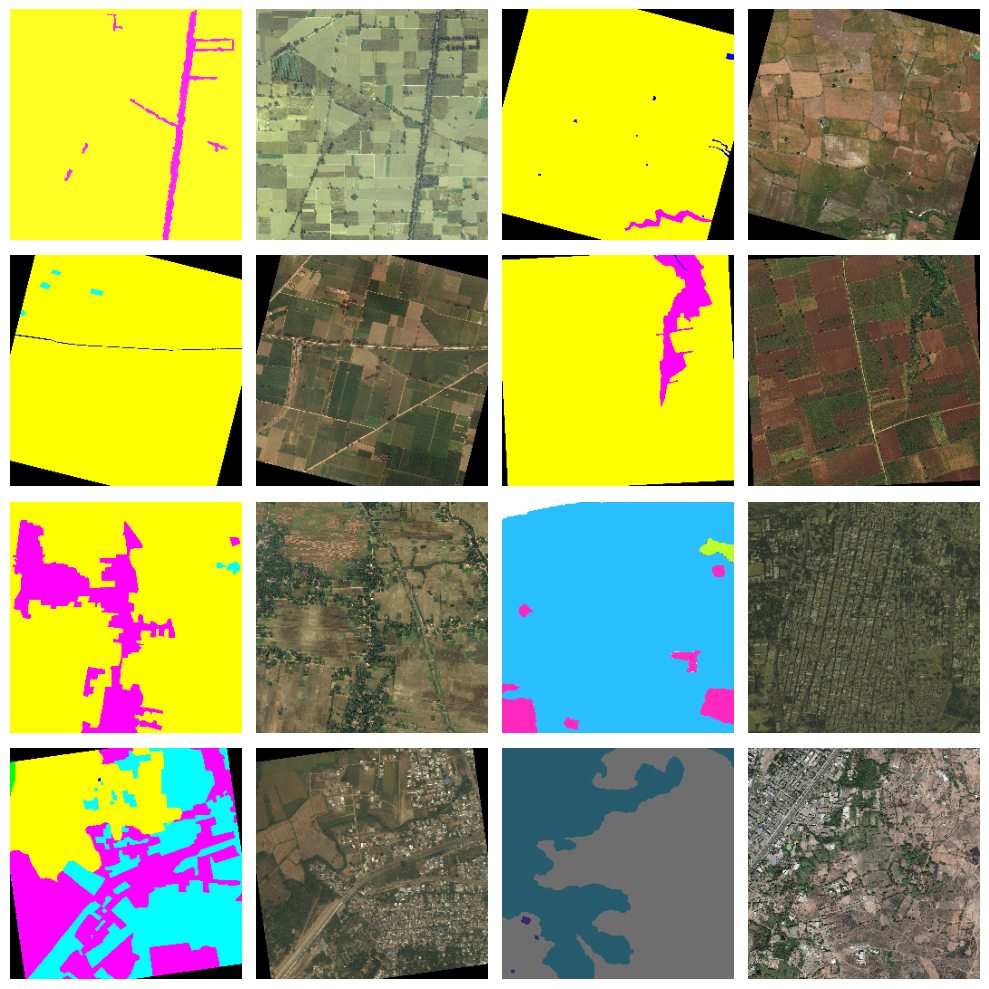

In [ ]:
import matplotlib.pyplot as plt
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, 4, figsize=(10, 10))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])
k = 0
dict1 = {name: rgb_to_name(class_to_rgb[name]) for name in class_to_rgb.keys()}
for i in range(nrows):
    for j in range(0, ncols, 2):
      img, mask = Segmentation_Dataset(train_dir, label_map, transform).__getitem__(k)
      k += 1
      axes[i, j].imshow(mask.permute(1, 2, 0))
      axes[i, j].axis('off')
      axes[i, j+1].imshow(img.permute(1, 2, 0))
      axes[i, j+1].axis('off')
plt.tight_layout()
# plt.show()

In [ ]:
xlabel = {'urban_land': 'cyan',
         'agriculture_land': 'yellow',
         'rangeland': 'magenta',
         'forest_land': 'lime',
         'water': 'blue',
         'barren_land': 'white',
         'unknown': 'black'}
label

{'urban_land': 'cyan',
 'agriculture_land': 'yellow',
 'rangeland': 'magenta',
 'forest_land': 'lime',
 'water': 'blue',
 'barren_land': 'white',
 'unknown': 'black'}

In [ ]:
import matplotlib.pyplot as plt
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, 4, figsize=(10, 10))
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.9, contrast=0.9, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
])
k = 0
dict1 = {name: rgb_to_name(class_to_rgb[name]) for name in class_to_rgb.keys()}
for i in range(nrows):
    for j in range(ncols):
      img, mask = Segmentation_Dataset(train_dir, label_map, transform1).__getitem__(k)
      k += 1

      axes[i, j].imshow(img)
      axes[i, j].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_image_grid(dataset, nrows=4, ncols=4):
    """
    Plot a grid of image-mask pairs from a dataset.

    Parameters:
    - dataset: an instance of a dataset class providing images and masks.
    - nrows: number of rows in the subplot grid.
    - ncols: number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            # Calculate the index for the current subplot
            idx = i * ncols + j
            if idx < len(dataset):
                img, mask = Segmentation_Dataset(train_dir, label_map, transform).__getitem__(k)
                k += 1
                axes[i, j].imshow(mask.numpy().transpose(2, 1, 0))
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide axis if there are no more items to display
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


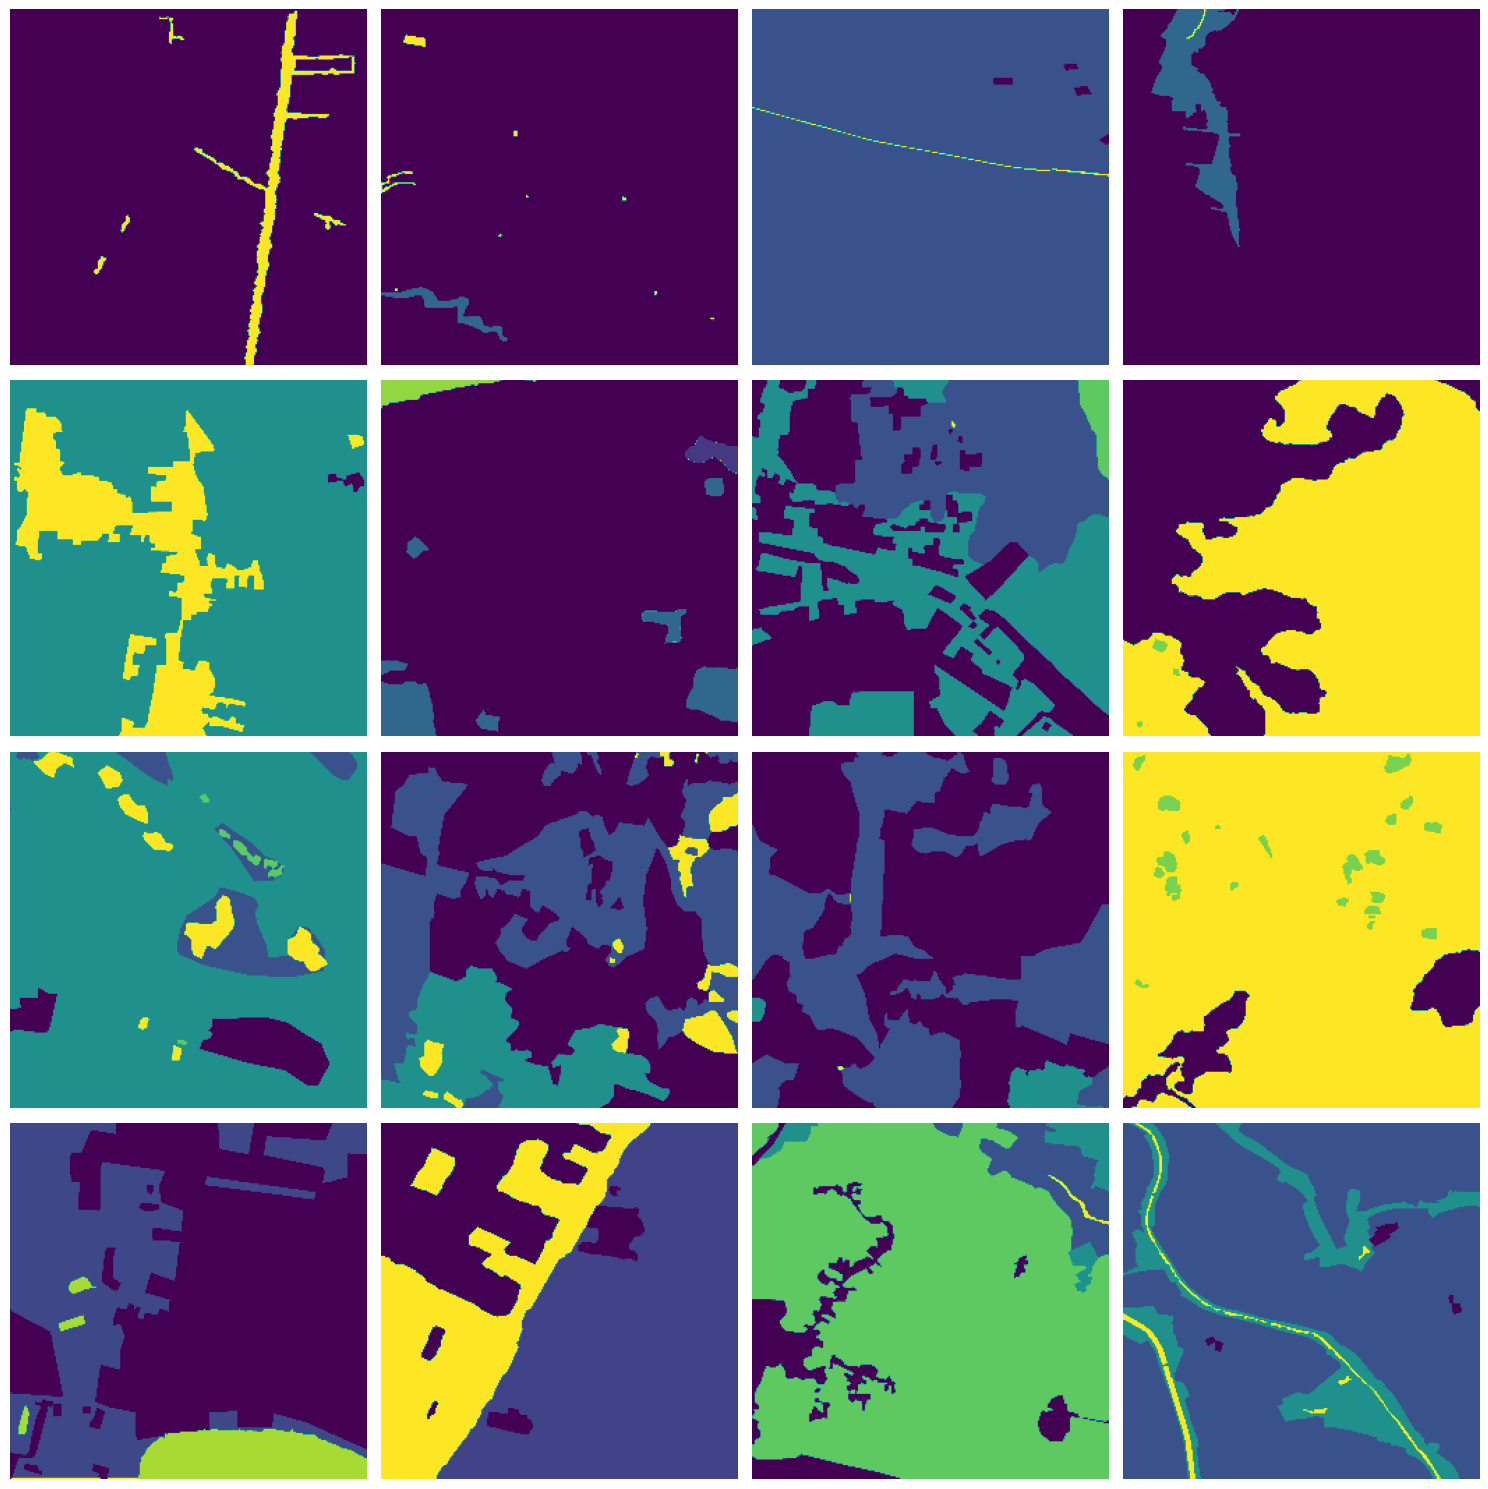

In [ ]:
plot_image_grid(train_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


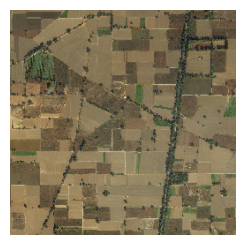

In [ ]:
img = Segmentation_Dataset(train_dir, label_map, transform).__getitem__(0)
sample = [img]
for i in range(len(sample)):
    plt.subplot(1, 2, i+1)
    plt.imshow(sample[i].numpy().transpose(1, 2, 0))
    plt.axis('off')
plt.show()

In [ ]:

plt.rcParams["savefig.bbox"] = "tight"
def show(imgs):
    #Helper function to show images in the torch format
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(100, 100))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class_to_rgb = {}
for idx, row in classes.iterrows():
    class_to_rgb[row[0]] = row[1:].to_list()
class_colors = [tuple(x) for x in class_to_rgb.values()]
num_classes = len(class_colors)

In [ ]:
print(f"Number of files in the train dir: {len(os.listdir(train_dir))}")
print(f"Number of files in the test dir : {len(os.listdir(test_dir))}")
print(f"Number of files in the valid dir: {len(os.listdir(valid_dir))}")

In [ ]:
transform = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])# TODO: compose transforms here
dataset = datasets.ImageFolder(data_dir, transform = transform)# TODO: create the ImageFolder
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [ ]:
def data_visualization(data, n):
    ## data: training or test data
    ## label: training or test labels
    ## n: number of data point, it should be less than or equal to no. of data points
    fig = plt.figure(figsize=(14, 14))
    ax = []  # ax enables access to manipulate each of subplots
    rows, columns=4,4
    for i in range(columns*rows):
        index=np.random.randint(1,n)
        img= data[index].reshape([28,28,4])[:,:,:3] ##reshape input data to rgb image
        ax.append( fig.add_subplot(rows, columns, i+1) ) # create subplot and append to ax
        #ax[-1].set_title("Class:"+str(label[index]))  # set class
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()  # finally, render the plot

In [ ]:
data_visualization(train_data, n=456)